In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import glob
import time
import math
import pickle as pkl
import torchvision as thv

from math import ceil
from omegaconf import OmegaConf
from sampler import BaseSampler
from utils import util_common
from utils import util_image
from torch.utils import data

from skimage.metrics import structural_similarity

/home/mds/anaconda3/envs/denoising/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from inference.diffusion_inference import DiffusionSampler as DiffusionSamplerWithoutMixing
from inference.diffusion_inference_w_mixing import DiffusionSampler as DiffusionSamplerWithMixing

In [3]:
def metrics_ssim(img1, img2):
    # apply max projection
    img1, img2 = np.max(img1, axis=0), np.max(img2, axis=0)
    data_range = max(np.max(img1), np.max(img2)) - min(np.min(img1), np.min(img2))
    # data_range = np.max(img1) - np.min(img1)
    # data_range = np.max(img2) - np.min(img2)
    (score, diff) = structural_similarity(img1, img2, full=True, data_range=data_range)
    return score

In [4]:
def plot_compare(noisy, denoised_without_mixing, denoised_with_mixing, gt):
    fig, ax = plt.subplots(1, 4, figsize=(20, 5))
    ax[0].imshow(noisy)
    ax[1].imshow(denoised_without_mixing)
    ax[2].imshow(denoised_with_mixing)
    ax[3].imshow(gt)
    ax[0].axis('off')
    ax[1].axis('off')
    ax[2].axis('off')
    ax[3].axis('off')
    ax[0].set_title('noisy')
    ax[1].set_title('denoised_without_mixing')
    ax[2].set_title('denoised_with_mixing')
    ax[3].set_title('gt')

# Setup

In [58]:
# model setup
cfg_path='/home/sivark/repos/denoising/open_source/DifFace/configs/sample/iddpm_planaria_LargeMdl.yaml'
gpu_id='0'
tN=100

transform = thv.transforms.Normalize(mean=(0.5), std=(0.5))
device = 'cuda' if torch.cuda.is_available() else 'cpu'
timestep_respacing = '1000'
configs = OmegaConf.load(cfg_path)
configs.gpu_id = gpu_id
configs.diffusion.params.timestep_respacing = timestep_respacing

tN = torch.tensor(tN).to(device)

In [59]:
%%time
# load val data
train_data_npz = '/home/sivark/supporting_files/denoising/data/planaria/Denoising_Planaria/train_data/data_label.npz'
noisy_key = 'X'
clean_key = 'Y'
noisy_data = np.load(train_data_npz)[noisy_key]
clean_data = np.load(train_data_npz)[clean_key]
split_fpth = '/home/sivark/supporting_files/denoising/trained_models/planaria_Train2TrainValTestv2.pkl'
split_to_infer = 'val_idx'
with open(split_fpth, 'rb') as pkl_f:
    splits = pkl.load(pkl_f)
noisy_data_val = noisy_data[splits['val_idx']].squeeze(axis=1)
clean_data_val = clean_data[splits['val_idx']].squeeze(axis=1)

CPU times: user 2.48 s, sys: 2.5 s, total: 4.98 s
Wall time: 5.01 s


In [60]:
noisy_data_val.shape, clean_data_val.shape

((1790, 16, 64, 64), (1790, 16, 64, 64))

In [61]:
%%time
# load N2V results (should exactly correspond to val set above)
n2v_outputs_npz = '/home/sivark/supporting_files/denoising/data/planaria/Denoising_Planaria/Train2TrainValTest_pred/n2v_pred_Train2TrainValTest_val_idxv2.npz'
n2v_outputs_val = np.load(n2v_outputs_npz)['pred']

CPU times: user 1.9 s, sys: 140 ms, total: 2.04 s
Wall time: 2.05 s


In [62]:
n2v_outputs_val.shape

(1790, 16, 64, 64)

In [63]:
# select a single image for testing
np.random.seed(0)
sample_idxs = np.random.choice(noisy_data_val.shape[0], size=1, replace=False)
print(sample_idxs)
noisy_data_sample = noisy_data_val[sample_idxs]
clean_data_sample = clean_data_val[sample_idxs]
n2v_data_sample = n2v_outputs_val[sample_idxs]
noisy_data_sample.shape, clean_data_sample.shape, n2v_data_sample.shape

[1465]


((1, 16, 64, 64), (1, 16, 64, 64), (1, 16, 64, 64))

# Compare results from mixing vs no mixing

This code tests whether mixing affects the results.

In [75]:
def test_with_vs_without_mixing(noisy_data_sample):
    # NOTE: for this test to work, each Sampler instance must be loaded and used exacly once, 
    # so that the random state is always exactly the same. otherwise you may get different results.
    
    img = torch.from_numpy(noisy_data_sample)
    y0 = transform(torch.permute(img.to(device), (1, 0, 2, 3)))

    sampler_dist_without_mixing = DiffusionSamplerWithoutMixing(configs)
    xN_given_y0 = sampler_dist_without_mixing.diffusion.q_sample(y0, tN)
    x0_sampled_without_mixing = sampler_dist_without_mixing.sample_func(
        noise=xN_given_y0,
        start_timesteps=tN,
        bs=len(y0),
        num_images=len(y0),
    )
    x0_sampled_without_mixing = x0_sampled_without_mixing.cpu().numpy().transpose(1,0,2,3).squeeze(axis=0)
    
    sampler_dist_with_mixing = DiffusionSamplerWithMixing(configs)
    xN_given_y0 = sampler_dist_with_mixing.diffusion.q_sample(y0, tN)
    x0_sampled_with_mixing = sampler_dist_with_mixing.sample_func(
        mixing_img_batch=y0,
        noise=xN_given_y0,
        start_timesteps=tN,
        bs=len(y0),
        num_images=len(y0),
    )
    x0_sampled_with_mixing = x0_sampled_with_mixing.cpu().numpy().transpose(1,0,2,3).squeeze(axis=0)
    return x0_sampled_without_mixing, x0_sampled_with_mixing

In [76]:
%time x0_sampled_without_mixing, x0_sampled_with_mixing = test_with_vs_without_mixing(noisy_data_sample)

Setting random seed 20000
Loading from /home/sivark/supporting_files/denoising/trained_models/diffusion/ckpts_from_shivesh/ema0999_model_580000_planaria.pth...
Loaded Done
Begining sampling:
Processing: 1/1
Setting random seed 20000
Loading from /home/sivark/supporting_files/denoising/trained_models/diffusion/ckpts_from_shivesh/ema0999_model_580000_planaria.pth...
Loaded Done
Begining sampling:
Processing: 1/1
CPU times: user 4.52 s, sys: 264 ms, total: 4.79 s
Wall time: 4.82 s


In [78]:
np.allclose(x0_sampled_without_mixing, x0_sampled_with_mixing)

True

Text(0, 0.5, 'pixel value (with mixing)')

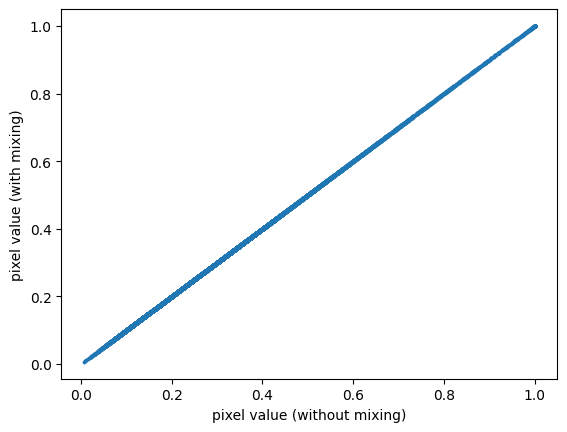

In [79]:
# correlate pixel values
plt.scatter(x0_sampled_without_mixing.flatten(), x0_sampled_with_mixing.flatten(), s=3)
plt.xlabel('pixel value (without mixing)')
plt.ylabel('pixel value (with mixing)')

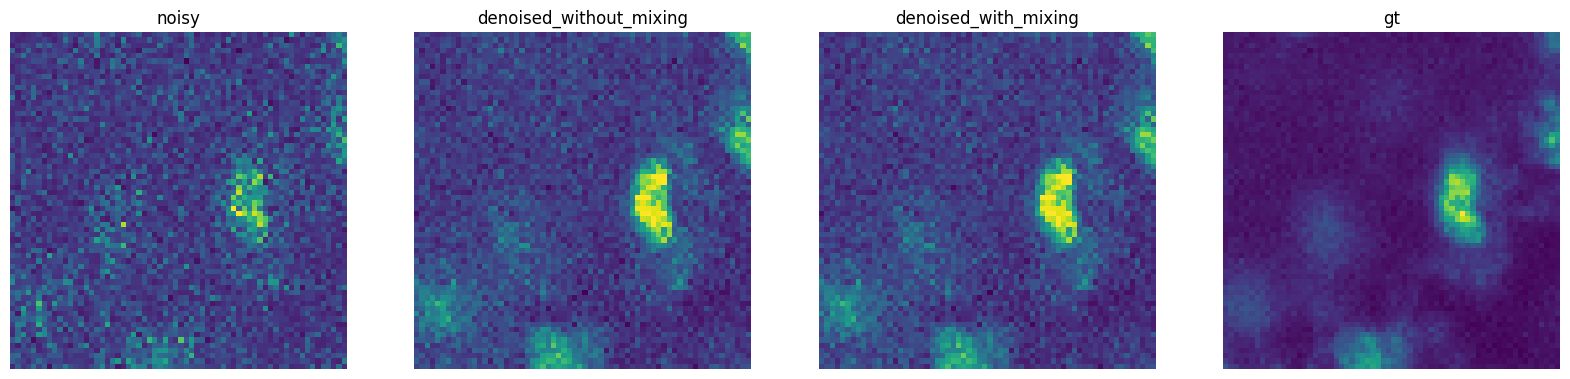

In [80]:
z = 8
plot_compare(
    noisy_data_sample[0,z,:,:],
    x0_sampled_without_mixing[z,:,:],
    x0_sampled_with_mixing[z,:,:],
    clean_data_sample[0,z,:,:],
)

In [81]:
print('SSIM noisy:', metrics_ssim(noisy_data_sample[0], clean_data_sample[0]))
print('SSIM diffusion without mixing:', metrics_ssim(x0_sampled_without_mixing, clean_data_sample[0]))
print('SSIM diffusion with mixing:', metrics_ssim(x0_sampled_with_mixing, clean_data_sample[0]))

SSIM noisy: 0.3358976102833878
SSIM diffusion without mixing: 0.5539204664744659
SSIM diffusion with mixing: 0.5539204664744659


# Repeat with other input images

In [85]:
sample_idxs = np.random.choice(noisy_data_val.shape[0], size=10, replace=False)
for sample_idx in sample_idxs:
    print('Val index:', sample_idx)
    noisy_data_sample = noisy_data_val[sample_idx][np.newaxis,]
    x0_sampled_without_mixing, x0_sampled_with_mixing = test_with_vs_without_mixing(noisy_data_sample)
    print('Outputs match:', np.allclose(x0_sampled_without_mixing, x0_sampled_with_mixing))
    print()

Val index: 1593
Setting random seed 20000
Loading from /home/sivark/supporting_files/denoising/trained_models/diffusion/ckpts_from_shivesh/ema0999_model_580000_planaria.pth...
Loaded Done
Begining sampling:
Processing: 1/1
Setting random seed 20000
Loading from /home/sivark/supporting_files/denoising/trained_models/diffusion/ckpts_from_shivesh/ema0999_model_580000_planaria.pth...
Loaded Done
Begining sampling:
Processing: 1/1
Outputs match: True

Val index: 743
Setting random seed 20000
Loading from /home/sivark/supporting_files/denoising/trained_models/diffusion/ckpts_from_shivesh/ema0999_model_580000_planaria.pth...
Loaded Done
Begining sampling:
Processing: 1/1
Setting random seed 20000
Loading from /home/sivark/supporting_files/denoising/trained_models/diffusion/ckpts_from_shivesh/ema0999_model_580000_planaria.pth...
Loaded Done
Begining sampling:
Processing: 1/1
Outputs match: True

Val index: 1338
Setting random seed 20000
Loading from /home/sivark/supporting_files/denoising/trai